<a href="https://colab.research.google.com/github/Bruno-Moreno/Tesis/blob/main/experiments/fast_dpp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mixed DPP Notebook

In [ ]:
#Import libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

#Sklearn functions
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
from sklearn.model_selection import train_test_split

#Keras functions
import tensorflow as tf
import keras

## First Iterations

### Dataset

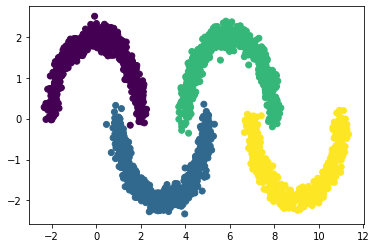

In [ ]:
np.random.seed(666)

def make_many_moons(
    number_of_moons,
    sigma, 
    radius, 
    number_of_datapoints,
    y_shift = 0.3
):
    
    moons = []
    for y in range(number_of_moons):
        q = np.random.uniform(0,np.pi,size=number_of_datapoints)
        
        if y % 2 == 0:
            factor = 1
        else: 
            factor = -1
        
        moon = np.zeros((number_of_datapoints, 3))
        moon[:,0] = (radius * np.cos(q)) + 3*y
        moon[:,1] = (radius * np.sin(q) * factor) + (factor == -1) * y_shift
        moon[:,2] = y
        moons.append(moon)
        noise = np.random.normal(0, sigma, size=moon[:,:2].shape)
        moon[:,:2] += noise
    moons = np.concatenate(moons)

    return moons[:,:2], moons[:,2]


number_of_datapoints = 600

X, y = make_many_moons(
    number_of_moons=4,
    sigma=0.15, 
    radius=2, 
    number_of_datapoints=number_of_datapoints,
    y_shift = 0 )


plt.scatter(X[:,0], X[:,1], c=y)

In [ ]:
np.random.seed(666)

def remove_points(X):

  #Remove some points of one of the classes
  train = pd.DataFrame(X)
  train["y"] = y 

  #Removing values 1
  remove_n = int(0.8*number_of_datapoints)
  drop_indices = np.random.choice(train.loc[train.y == 0 , :].index, remove_n, replace=False)
  df_subset = train.drop(drop_indices, axis = 0)

  #Removing values 2
  remove_n = int(0.2*number_of_datapoints)
  drop_indices = np.random.choice(df_subset.loc[df_subset.y == 1 , :].index, remove_n, replace=False)
  df_subset_2 = df_subset.drop(drop_indices, axis = 0)
  print(df_subset_2.y.value_counts())

  df = df_subset_2.copy()

  #Now we make two of the colors the same
  df["y"] = np.where((df_subset_2["y"].values == 0) | (df_subset_2["y"].values == 1), 0, 1)

  fig = plt.scatter(df[0], df[1], c=df["y"])
  plt.legend(handles=fig.legend_elements()[0], labels=["0" , "1"], title="Clase")
  print(df.y.value_counts())

  return df

NameError: ignored

In [ ]:
df = remove_points(X)
df

In [ ]:
X = df.drop(columns = ["y"]).to_numpy()
y = df["y"].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666 , stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=666 , stratify = y_train)

X_train = X_train.reshape((len(X_train),2,1))
X_val = X_val.reshape((len(X_val),2,1))
X_test = X_test.reshape((len(X_test),2,1))

y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
y_val = np.asarray(y_val).astype('float32').reshape((-1,1))

print(f'Train Shape: {X_train.shape}')
print(f'Val Shape: {X_val.shape}')
print(f'Test Shape: {X_test.shape}')

### FFNN

In [ ]:
!pip install dppy
!pip install umap-learn
!pip install -U pydpp

In [ ]:
# Import usual libraries
import time 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import random

# Import other libaries
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Reshape

#Import DPP libraries
from pydpp.dpp import DPP
from sklearn.gaussian_process.kernels import PairwiseKernel

#Functions
from sklearn.metrics import accuracy_score , pairwise_distances
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
from sklearn.model_selection import train_test_split

#Others 
import warnings
warnings.filterwarnings("ignore")

### Decision Surface

In [ ]:
def create_grid(X):
  # define bounds of the domain
  min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
  min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1

  # define the x and y scale
  x1grid = np.arange(min1, max1, 0.1)
  x2grid = np.arange(min2, max2, 0.1)

  # create all of the lines and rows of the grid
  xx, yy = np.meshgrid(x1grid, x2grid)

  r1, r2 = xx.flatten(), yy.flatten()
  r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

  # horizontal stack vectors to create x1,x2 input for the model
  grid = np.hstack((r1,r2))

  return xx,yy,grid

xx,yy,grid = create_grid(X)
grid





### Train

In [ ]:
import time 

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

class mini_batch_sampling(tf.keras.utils.Sequence):
  def __init__(self, images, labels, batch_size=128, shuffle=True):
    super().__init__()
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.shuffle = shuffle
    key_array = []
    self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)
    self.on_epoch_end()

  def __len__(self):
    return len(self.key_array)//self.batch_size

  def __getitem__(self, index):
    keys = self.key_array[index*self.batch_size:(index+1)*self.batch_size]

    x = np.asarray(self.images[keys], dtype=np.float32)
    y = np.asarray(self.labels[keys], dtype=np.float32)

    #Create grid
    y_hat = model.predict(grid)
    y_hat_binary = np.where(y_hat >= 0.5, 1 , 0)
    #y_hat_multiclass = np.argmax(y_hat, axis=-1)

    # plot the grid of x, y and z values as a surface
    zz = y_hat_binary.reshape(xx.shape)
    #zz = y_hat_multiclass.reshape(xx.shape)
    plt.contourf(xx, yy, zz, cmap='Paired')

    #zz = y_hat.reshape(xx.shape)
    #c = plt.contourf(xx, yy, zz, cmap='RdBu')
    #plt.colorbar(c)

    # create scatter plot for samples from each class
    #for class_value in range(3):
    for class_value in range(2):
      # get row indexes for samples with this class
      row_ix = np.where(y_train == class_value)
      # create scatter of these samples
      plt.scatter(X_train[row_ix, 0], X_train[row_ix, 1], cmap='Paired', label = f"class = {class_value}")
      # show the plot

    #for value in x:
    #  plt.scatter(value[0], value[1], c = 'black', marker = 'o')

    plt.scatter(x[: , 0], x[: , 1], c = 'black', cmap = "Paired", marker = 'o', label = "batch")

    plt.legend()
    plt.show()

    return x, y

  def on_epoch_end(self):
    if self.shuffle:
      self.key_array = np.random.permutation(self.key_array)

    """#Create grid
    y_hat = model.predict(grid)
    y_hat_binary = np.where(y_hat >= 0.5, 1 , 0)

    # plot the grid of x, y and z values as a surface
    zz = y_hat_binary.reshape(xx.shape)
    plt.contourf(xx, yy, zz, cmap='Paired')

    #zz = y_hat.reshape(xx.shape)
    #c = plt.contourf(xx, yy, zz, cmap='RdBu')
    #plt.colorbar(c)

    # create scatter plot for samples from each class
    for class_value in range(2):
      # get row indexes for samples with this class
      row_ix = np.where(y_train == class_value)
      # create scatter of these samples
      plt.scatter(X_train[row_ix, 0], X_train[row_ix, 1], cmap='Paired', label = f"class = {class_value}")
      # show the plot
    plt.legend()
    plt.show()"""


In [ ]:
def FFNN(shape):
  model = Sequential()
  model.add(Flatten(input_shape = shape))
  model.add(Dense(1000 , activation = "tanh"))
  model.add(Dense(100 , activation = "relu"))
  model.add(Dense(50 , activation = "tanh"))
  model.add(Dense(1 , activation = "sigmoid"))
  model.summary()

  return model

def FFNN_2(shape):
  model = Sequential()
  model.add(Flatten(input_shape = shape))
  model.add(Dense(1000 , activation = "tanh"))
  model.add(Dense(100 , activation = "relu"))
  model.add(Dense(50 , activation = "tanh"))
  model.add(Dense(4 , activation = "sigmoid"))
  model.summary()

  return model

In [ ]:
#Creating the models 
epochs = 2
batch_size = 64
shape = (2,1)

model = FFNN(shape)
#model = FFNN_2(shape)

global model

#Creating the generator
generator_uniform = mini_batch_sampling(images = X_train, labels = y_train , batch_size = batch_size, shuffle = True)

#Compile
model.compile("adam", loss = ['binary_crossentropy'] , metrics = ["accuracy"])
#model.compile("adam", loss = ['categorical_crossentropy'] , metrics = ["accuracy"])

#Fit
time_callback = TimeHistory()
history = model.fit_generator(generator_uniform, epochs=epochs, steps_per_epoch =-1, 
                    validation_data=(X_test, y_test), verbose=1, callbacks = [time_callback])

#print(time_callback.times)
#pd.DataFrame(history.history).plot()

In [ ]:
class DPP_RBF(tf.keras.utils.Sequence):
  def __init__(self, images, labels, batch_size=128, N = 100, shuffle=True):
    super().__init__()
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.N = N
    key_array = []
    self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)
    self.on_epoch_end()

  def __len__(self):
    return len(self.key_array)//self.batch_size

  def __getitem__(self, index):
    
    random_keys = self.key_array

    tmp_x = self.images[random_keys]
    tmp_y = self.labels[random_keys]

    if self.batch_size < tmp_x.shape[0]:
      
      dpp = DPP(tmp_x.reshape((-1,2)))
      dpp.compute_kernel(kernel_type = 'rbf', sigma= 1)                  
      keys_DPP = dpp.sample_k(self.batch_size) 

      x = np.asarray(tmp_x[keys_DPP], dtype=np.float32)
      y = np.asarray(tmp_y[keys_DPP], dtype=np.float32)

      self.key_array = np.delete(self.key_array , keys_DPP)

    else:

      x = np.asarray(tmp_x, dtype=np.float32)
      y = np.asarray(tmp_y, dtype=np.float32)

    #self.key_array = self.key_array[~np.isin(self.key_array, random_keys[keys_DPP])]

    #Create grid
    y_hat = model.predict(grid)
    y_hat_binary = np.where(y_hat >= 0.5, 1 , 0)

    # plot the grid of x, y and z values as a surface
    zz = y_hat_binary.reshape(xx.shape)
    plt.contourf(xx, yy, zz, cmap='Paired')

    #zz = y_hat.reshape(xx.shape)
    #c = plt.contourf(xx, yy, zz, cmap='RdBu')
    #plt.colorbar(c)

    # create scatter plot for samples from each class
    for class_value in range(2):
      # get row indexes for samples with this class
      row_ix = np.where(y_train == class_value)
      # create scatter of these samples
      plt.scatter(X_train[row_ix, 0], X_train[row_ix, 1], cmap='Paired', label = f"class = {class_value}")
      # show the plot

    #for value in x:
    #  plt.scatter(value[0], value[1], c = 'black', marker = 'o')

    plt.scatter(x[: , 0], x[: , 1], c = 'black', cmap = "Paired", marker = 'o', label = "batch")

    plt.legend()
    plt.show()

    return x, y

  def on_epoch_end(self):
    self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)

    #Create grid
    y_hat = model.predict(grid)
    y_hat_binary = np.where(y_hat >= 0.5, 1 , 0)

    # plot the grid of x, y and z values as a surface
    zz = y_hat_binary.reshape(xx.shape)
    plt.contourf(xx, yy, zz, cmap='Paired')

    #zz = y_hat.reshape(xx.shape)
    #c = plt.contourf(xx, yy, zz, cmap='RdBu')
    #plt.colorbar(c)

    # create scatter plot for samples from each class
    for class_value in range(2):
      # get row indexes for samples with this class
      row_ix = np.where(y_train == class_value)
      # create scatter of these samples
      plt.scatter(X_train[row_ix, 0], X_train[row_ix, 1], cmap='Paired', label = f"class = {class_value}")
      # show the plot
    plt.legend()
    plt.show()

In [ ]:
#Creating the models 
epochs = 2
batch_size = 64
shape = (2,1)

model = FFNN(shape)
global model

#Creating the generator
generator_DPP = DPP_RBF(images = X_train, labels=y_train, 
                        batch_size=batch_size, N = 500, shuffle=False)

#Compile
model.compile("adam", loss = ['binary_crossentropy'] , metrics = ["accuracy"])

#Fit
time_callback = TimeHistory()
history = model.fit_generator(generator_DPP, epochs=epochs, steps_per_epoch =-1, 
                              validation_data=(X_test, y_test), verbose=1, callbacks = [time_callback])

#print(time_callback.times)
pd.DataFrame(history.history).plot()

## Binary Classification

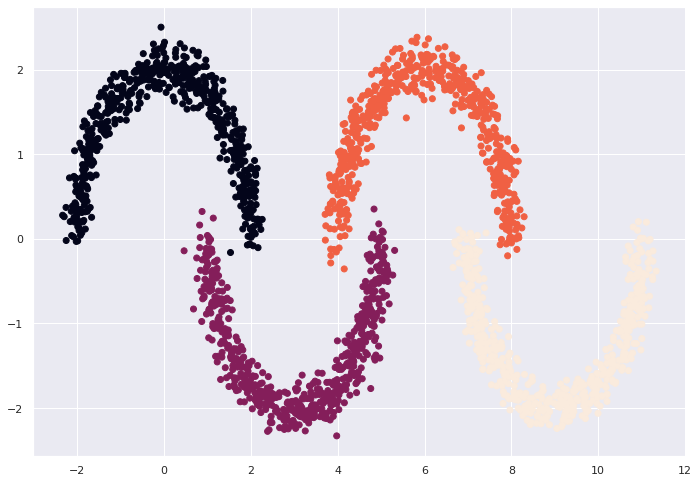

In [ ]:
np.random.seed(666)

def make_many_moons(
    number_of_moons,
    sigma, 
    radius, 
    number_of_datapoints,
    y_shift = 0.3
):
    
    moons = []
    for y in range(number_of_moons):
        q = np.random.uniform(0,np.pi,size=number_of_datapoints)
        
        if y % 2 == 0:
            factor = 1
        else: 
            factor = -1
        
        moon = np.zeros((number_of_datapoints, 3))
        moon[:,0] = (radius * np.cos(q)) + 3*y
        moon[:,1] = (radius * np.sin(q) * factor) + (factor == -1) * y_shift
        moon[:,2] = y
        moons.append(moon)
        noise = np.random.normal(0, sigma, size=moon[:,:2].shape)
        moon[:,:2] += noise
    moons = np.concatenate(moons)

    return moons[:,:2], moons[:,2]


number_of_datapoints = 600

X, y = make_many_moons(
    number_of_moons=4,
    sigma=0.15, 
    radius=2, 
    number_of_datapoints=number_of_datapoints,
    y_shift = 0 )


plt.scatter(X[:,0], X[:,1], c=y)

In [ ]:
np.random.seed(666)

def remove_points(X):

  #Remove some points of one of the classes
  train = pd.DataFrame(X)
  train["y"] = y 

  #Removing values 1
  remove_n = int(0.8*number_of_datapoints)
  drop_indices = np.random.choice(train.loc[train.y == 0 , :].index, remove_n, replace=False)
  df_subset = train.drop(drop_indices, axis = 0)

  #Removing values 2
  remove_n = int(0.2*number_of_datapoints)
  drop_indices = np.random.choice(df_subset.loc[df_subset.y == 1 , :].index, remove_n, replace=False)
  df_subset_2 = df_subset.drop(drop_indices, axis = 0)
  print(df_subset_2.y.value_counts())

  df = df_subset_2.copy()

  #Now we make two of the colors the same
  df["y"] = np.where((df_subset_2["y"].values == 0) | (df_subset_2["y"].values == 1), 0, 1)

  fig = plt.scatter(df[0], df[1], c=df["y"])
  plt.legend(handles=fig.legend_elements()[0], labels=["0" , "1"], title="Clase")
  print(df.y.value_counts())

  return df

2.0    600
3.0    600
1.0    480
0.0    120
Name: y, dtype: int64
1    1200
0     600
Name: y, dtype: int64


,0,1,y
2,-0.870870,1.402186,0
9,-0.191063,2.197001,0
10,1.286711,0.954529,0
16,2.144180,0.232238,0
24,-2.051243,0.340942,0
...,...,...,...
2395,10.811768,-0.743692,1
2396,10.272529,-1.447182,1
2397,9.271070,-1.859441,1
2398,10.200049,-1.839066,1


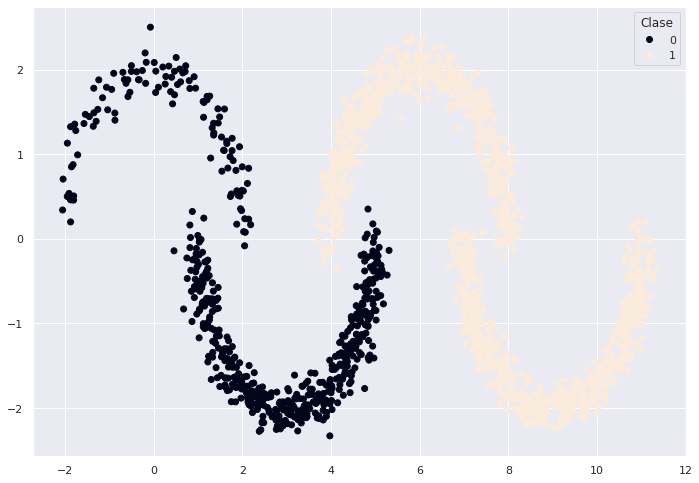

In [ ]:
df = remove_points(X)
df

In [ ]:
X = df.drop(columns = ["y"]).to_numpy()
y = df["y"].to_numpy().ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=666 , stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=666 , stratify = y_train)

X_train = X_train.reshape((len(X_train),2,1))
X_val = X_val.reshape((len(X_val),2,1))
X_test = X_test.reshape((len(X_test),2,1))

y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
y_val = np.asarray(y_val).astype('float32').reshape((-1,1))

print(f'Train Shape: {X_train.shape}')
print(f'Val Shape: {X_val.shape}')
print(f'Test Shape: {X_test.shape}')

Train Shape: (1152, 2, 1)
Val Shape: (288, 2, 1)
Test Shape: (360, 2, 1)


In [ ]:
!pip install dppy
!pip install umap-learn
!pip install -U pydpp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import usual libraries
import time 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import random

# Import other libaries
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Reshape

#Import DPP libraries
from pydpp.dpp import DPP
from sklearn.gaussian_process.kernels import PairwiseKernel

#Functions
from sklearn.metrics import accuracy_score , pairwise_distances
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
from sklearn.model_selection import train_test_split

#Others 
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import time 

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

class mini_batch_sampling(tf.keras.utils.Sequence):
  def __init__(self, images, labels, batch_size=128, shuffle=True):
    super().__init__()
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.shuffle = shuffle
    key_array = []
    self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)
    self.on_epoch_end()

  def __len__(self):
    return len(self.key_array)//self.batch_size

  def __getitem__(self, index):
    keys = self.key_array[index*self.batch_size:(index+1)*self.batch_size]

    x = np.asarray(self.images[keys], dtype=np.float32)
    y = np.asarray(self.labels[keys], dtype=np.float32)


    return x, y

  def on_epoch_end(self):
    if self.shuffle:
      self.key_array = np.random.permutation(self.key_array)


In [ ]:
def FFNN(shape):
  model = Sequential()
  model.add(Flatten(input_shape = shape))
  model.add(Dense(1000 , activation = "tanh"))
  model.add(Dense(100 , activation = "relu"))
  model.add(Dense(50 , activation = "tanh"))
  model.add(Dense(1 , activation = "sigmoid"))
  model.summary()

  return model

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_19 (Flatten)        (None, 2)                 0         
                                                                 
 dense_45 (Dense)            (None, 1000)              3000      
                                                                 
 dense_46 (Dense)            (None, 100)               100100    
                                                                 
 dense_47 (Dense)            (None, 50)                5050      
                                                                 
 dense_48 (Dense)            (None, 1)                 51        
                                                                 
Total params: 108,201
Trainable params: 108,201
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
18/18 [==============================] - 2s 20ms/step - loss: 0.3122 - accuracy: 0.8559 - val_loss: 0.1880 - val_accuracy: 0.9361
Epoch 2/10
18/18 [==============================] - 0s 7ms/step - loss: 0.1800 - accuracy: 0.9323 - val_loss: 0.1369 - val_accuracy: 0.9472
Epoch 3/10
18/18 [==============================] - 0s 7ms/step - loss: 0.1386 - accuracy: 0.9514 - val_loss: 0.1013 - val_accuracy: 0.9583
Epoch 4/10
18/18 [==============================] - 0s 7ms/step - loss: 0.1055 - accuracy: 0.9618 - val_loss: 0.1111 - val_accuracy: 0.9556
Epoch 5/10
18/18 [==============================] - 0s 6ms/step - loss: 0.1040 - accuracy: 0.9514 - val_loss: 0.0862 - val_accuracy: 0.9750
Epoch 6/10
18/18 [==============================] - 0s 7ms/step - loss: 0.0959 - accuracy: 0.9653 - val_loss: 0.0692 - val_accuracy: 0.9694
Epoch 7/10
18/18 [==============================] - 0s 7ms/step - loss: 0.0785 - accuracy: 0.9705 - val_loss: 0.0619 - val_accuracy: 0.9750
Epoch 8/10
18/18 [=

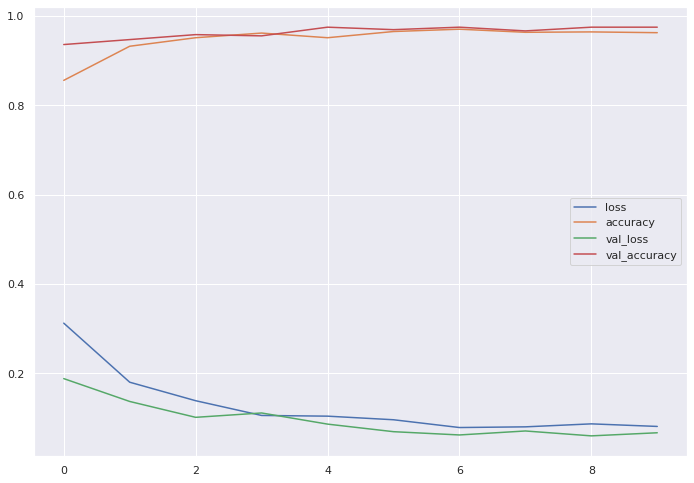

In [ ]:
#Creating the models 
epochs = 10
batch_size = 64
shape = (2,1)

model = FFNN(shape)
#model = FFNN_2(shape)

global model

#Creating the generator
generator_uniform = mini_batch_sampling(images = X_train, labels = y_train , batch_size = batch_size, shuffle = True)

#Compile
model.compile("adam", loss = ['binary_crossentropy'] , metrics = ["accuracy"])
#model.compile("adam", loss = ['categorical_crossentropy'] , metrics = ["accuracy"])

#Fit
time_callback = TimeHistory()
history = model.fit_generator(generator_uniform, epochs=epochs, steps_per_epoch =-1, 
                    validation_data=(X_test, y_test), verbose=1, callbacks = [time_callback])

print(time_callback.times)
pd.DataFrame(history.history).plot()

In [ ]:
class DPP_RBF_Fast(tf.keras.utils.Sequence):
  def __init__(self, images, labels, batch_size=128, N = 100, shuffle=True):
    super().__init__()
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.N = N
    key_array = []
    self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)
    self.on_epoch_end()

  def __len__(self):
    return len(self.key_array)//self.N

  def __getitem__(self, index):
    #keys = self.key_array[index*self.N:(index+1)*self.N]
    print(f'Key Array Shape: {len(self.key_array)}')

    if len(self.key_array) > self.N:

      random_keys = np.random.choice(self.key_array , self.N , replace = False)

    else:

      random_keys = self.key_array

    tmp_x = self.images[random_keys]
    tmp_y = self.labels[random_keys]

    """DPP = FiniteDPP('likelihood',
                    **{'L_eval_X_data': (self.kernel, tmp_x.reshape( (len(tmp_x) , 2) ) )})
    
    #DPP.sample_mcmc_k_dpp(size=self.batch_size)
    DPP.sample_exact_k_dpp(size=self.batch_size)
    #keys_DPP = DPP.list_of_samples[0][0]
    keys_DPP = DPP.list_of_samples[0]"""

    dpp = DPP(tmp_x.reshape((-1,2)))
    dpp.compute_kernel(kernel_type = 'rbf', sigma= 1)                  
    keys_DPP = dpp.sample_k(self.batch_size) 

    x = np.asarray(tmp_x[keys_DPP], dtype=np.float32)
    y = np.asarray(tmp_y[keys_DPP], dtype=np.float32)

    #self.key_array = np.delete(self.key_array , keys_DPP)
    self.key_array = self.key_array[~np.isin(self.key_array, random_keys)]

    return x, y

  def on_epoch_end(self):
    self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 2)                 0         
                                                                 
 dense_49 (Dense)            (None, 1000)              3000      
                                                                 
 dense_50 (Dense)            (None, 100)               100100    
                                                                 
 dense_51 (Dense)            (None, 50)                5050      
                                                                 
 dense_52 (Dense)            (None, 1)                 51        
                                                                 
Total params: 108,201
Trainable params: 108,201
Non-trainable params: 0
_________________________________________________________________
Key Array Shape: 1152


Epoch 1/10
Key Array Shape: 1052
Key Array Shape: 952
      1/Unknown - 1s 1s/step - loss: 0.7411 - accuracy: 0.3750Key Array Shape: 852
      2/Unknown - 1s 155ms/step - loss: 0.5998 - accuracy: 0.5391Key Array Shape: 752
      3/Unknown - 1s 145ms/step - loss: 0.5771 - accuracy: 0.5781Key Array Shape: 652
      4/Unknown - 1s 137ms/step - loss: 0.5582 - accuracy: 0.5977Key Array Shape: 552
      5/Unknown - 2s 132ms/step - loss: 0.5583 - accuracy: 0.6062Key Array Shape: 452
      7/Unknown - 2s 132ms/step - loss: 0.5139 - accuracy: 0.6585Key Array Shape: 352
Key Array Shape: 252
      8/Unknown - 2s 132ms/step - loss: 0.4989 - accuracy: 0.6797Key Array Shape: 152
10/10 [==============================] - 2s 160ms/step - loss: 0.4668 - accuracy: 0.7250 - val_loss: 0.3011 - val_accuracy: 0.9111
Epoch 2/10
Key Array Shape: 1152
Key Array Shape: 1052
10/10 [==============================] - 2s 158ms/step - loss: 0.2865 - accuracy: 0.8938 - val_loss: 0.2059 - val_accuracy: 0.9306
Epoch 3/1

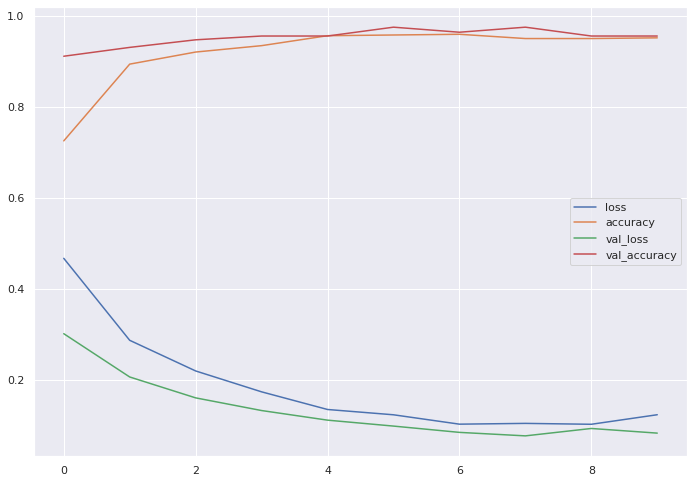

In [ ]:
#Creating the models 
epochs = 10
batch_size = 64
shape = (2,1)

model = FFNN(shape)
global model

#Creating the generator
generator_DPP = DPP_RBF_Fast(images = X_train, labels=y_train, 
                        batch_size=batch_size, N = 100, shuffle=False)

#Compile
model.compile("adam", loss = ['binary_crossentropy'] , metrics = ["accuracy"])

#Fit
time_callback = TimeHistory()

history = model.fit_generator(generator_DPP, epochs=epochs, steps_per_epoch =-1, 
                              validation_data=(X_test, y_test), verbose=1, callbacks = [time_callback])

#print(time_callback.times)
pd.DataFrame(history.history).plot()

In [ ]:
from IPython.display import display, clear_output

def cum_sum(time_list):
  cumtime = time_list[0]
  cumsum = [cumtime]
  for time in time_list[1:]:
    cumtime += time
    cumsum.append(cumtime)

  return cumsum

def plot_confidence(n):

  #Creating the models 
  epochs = 10
  batch_size = 64
  shape = (2,1)
  historial = pd.DataFrame()
  

  for i in range(n):
    
    print(f'Iteration: {i}')

    #####################
    #Baseline
    #####################

    model = FFNN(shape)

    #Creating the generator
    generator_uniform = mini_batch_sampling(images = X_train, labels = y_train , 
                                            batch_size = batch_size, shuffle = True)

    #Compile
    model.compile("adam", loss = ['binary_crossentropy'] , metrics = ["accuracy"])

    #Fit
    time_callback = TimeHistory()

    history = model.fit_generator(generator_uniform, epochs=epochs, steps_per_epoch =-1, 
                        validation_data=(X_test, y_test), verbose=1, callbacks = [time_callback])
    
    history = pd.DataFrame(history.history)
    
    loss = history[["loss"]]
    loss["val_loss"] = history[["val_loss"]]
    loss["val_accuracy"] = history[["val_accuracy"]]
    loss["time"] =  np.array(time_callback.times).cumsum()
    loss["epoch"] = list(range(1,epochs+1))
    loss["method"] = "baseline"
    #loss["time"] = cum_sum(time_list)
    historial = pd.concat([historial , loss], axis = 0)

    clear_output(wait=True)

    #####################
    #DPP
    #####################

    model = FFNN(shape)

    #Creating the generator
    generator_DPP = DPP_RBF_Fast(images = X_train, labels=y_train, 
                            batch_size=batch_size, N = 100, shuffle=False)

    #Compile
    model.compile("adam", loss = ['binary_crossentropy'] , metrics = ["accuracy"])

    #Fit
    time_callback = TimeHistory()

    history_DPP = model.fit_generator(generator_DPP, epochs=epochs, steps_per_epoch =-1, 
                                  validation_data=(X_test, y_test), verbose=1, callbacks = [time_callback])

    history_DPP = pd.DataFrame(history_DPP.history)

    loss = history_DPP[["loss"]]
    loss["val_loss"] = history_DPP[["val_loss"]]
    loss["val_accuracy"] = history_DPP[["val_accuracy"]]
    loss["epoch"] = list(range(1, epochs+1))
    loss["time"] =  np.array(time_callback.times).cumsum()
    loss["method"] = "DPP"
    #loss["time"] = cum_sum(time_list_DPP)
    historial = pd.concat([historial , loss], axis = 0)

    clear_output(wait=True)


  historial.reset_index(drop = True , inplace = True)


  return historial

train_historial = plot_confidence(n = 5)
train_historial

,loss,val_loss,val_accuracy,time,epoch,method
0,0.353281,0.213343,0.927778,1.852063,1,baseline
1,0.197637,0.150026,0.944444,2.055436,2,baseline
2,0.161247,0.116987,0.955556,2.302033,3,baseline
3,0.120040,0.113461,0.955556,2.561014,4,baseline
4,0.100055,0.078064,0.969444,2.809521,5,baseline
...,...,...,...,...,...,...
95,0.117438,0.094930,0.958333,7.690343,6,DPP
96,0.111912,0.086574,0.975000,8.985418,7,DPP
97,0.098601,0.083934,0.975000,10.052266,8,DPP
98,0.098270,0.074001,0.975000,11.190327,9,DPP


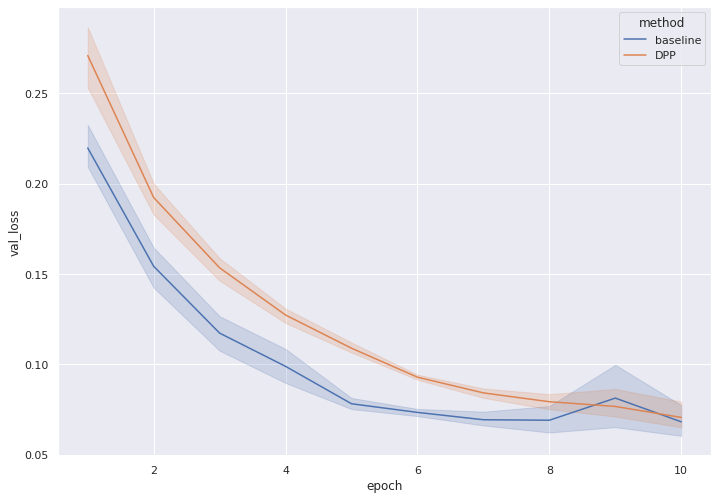

In [ ]:
import seaborn as sns 

#Plotting
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="epoch", y= "val_loss", hue = "method", data = train_historial)

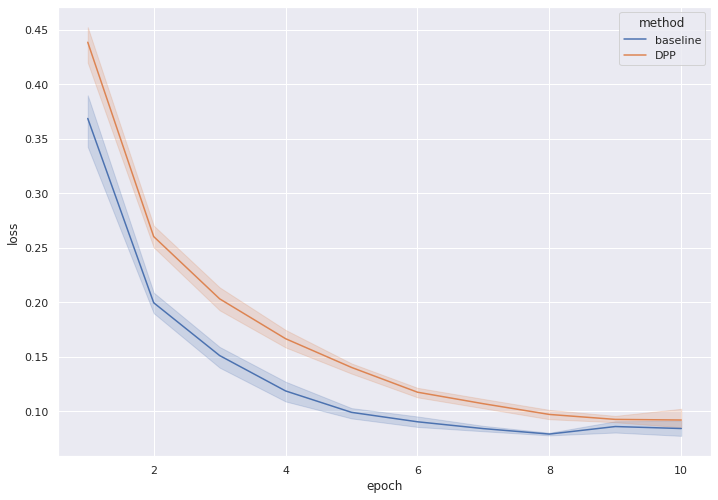

In [ ]:
#Plotting
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="epoch", y= "loss", hue = "method", data = train_historial)

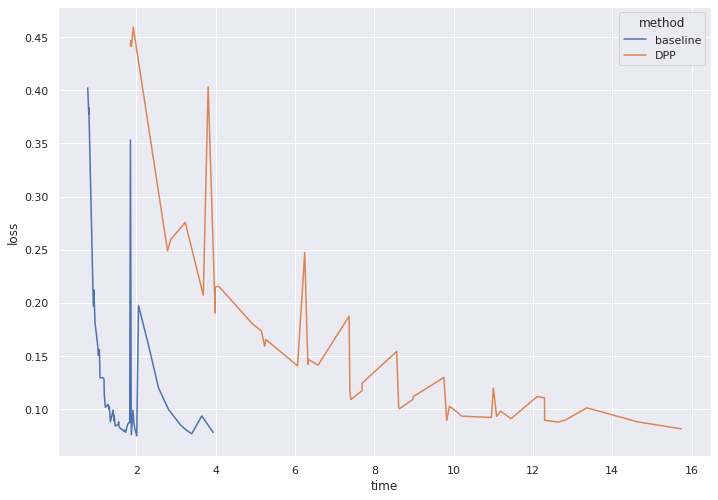

In [ ]:
#Plotting
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="time", y= "loss", hue = "method",  data = train_historial)

## Multiclass Classification

In [ ]:
!pip install dppy
!pip install umap-learn
!pip install -U pydpp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 KB 5.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=534d8df59ddd1d8a5e20b9b919db229483cb1ff5c8a6fd182c90b4a9538c2123
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=d2f631d6b2325e4d3b7abbb3cbe33656f69a6a1680c7e2c04b237f9e68d5f01e
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/

In [ ]:
# Import usual libraries
import time 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import random

# Import other libaries
import tensorflow as tf
import keras
from keras.models import Sequential , Model
from keras import backend as K
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Reshape
from keras.layers import Lambda
from keras.layers import BatchNormalization


#Import DPP libraries
from pydpp.dpp import DPP
from sklearn.gaussian_process.kernels import PairwiseKernel

#Functions
from sklearn.metrics import accuracy_score , pairwise_distances
from sklearn.datasets import make_moons, make_circles, make_classification, make_blobs
from sklearn.model_selection import train_test_split

#Others 
import warnings
warnings.filterwarnings("ignore")


In [ ]:
def dataset(name):
  if name == "FASHION_MNIST":

    fashion_mnist = keras.datasets.fashion_mnist
    (X_train_full,y_train_full) , (X_test , y_test) = fashion_mnist.load_data()

    X_val , X_train =  X_train_full[:5000] / 255.0 , X_train_full[5000:] / 255.0
    y_val , y_train =  y_train_full[:5000]  , y_train_full[5000:] 

    print(f'Train Shape: {X_train.shape}')
    print(f'Val Shape: {X_val.shape}')
    print(f'Test Shape: {X_test.shape}')

    return X_train , y_train , X_val, y_val , X_test , y_test

  elif name == "MNIST":

    mnist = keras.datasets.mnist
    (X_train_full,y_train_full) , (X_test , y_test) = mnist.load_data()

    X_val , X_train =  X_train_full[:5000] / 255.0 , X_train_full[5000:] / 255.0
    y_val , y_train =  y_train_full[:5000]  , y_train_full[5000:] 

    print(f'Train Shape: {X_train.shape}')
    print(f'Val Shape: {X_val.shape}')
    print(f'Test Shape: {X_test.shape}')

    return X_train , y_train , X_val, y_val , X_test , y_test

  else: 
    print("Error")

X_train , y_train , X_val, y_val , X_test , y_test = dataset("FASHION_MNIST")

4422102/4422102 [==============================] - 0s 0us/step
Train Shape: (55000, 28, 28)
Val Shape: (5000, 28, 28)
Test Shape: (10000, 28, 28)


In [ ]:
def get_samples_train(X, y , clase):
  data = pd.DataFrame(X.reshape((len(X), 28*28)))
  data["y"] = y
  if clase < 4:
    samples = data.loc[data.y == clase, :].sample(2500, random_state = 666)
  elif clase < 7:
    samples = data.loc[data.y == clase, :].sample(1500, random_state = 666)
  else:
    samples = data.loc[data.y == clase, :].sample(500, random_state = 666)

  return list(samples.index)

In [ ]:
samples_list = []
for i in range(10):
  samples_list += get_samples_train(X_train, y_train, i)
  
train = pd.DataFrame(X_train.reshape((len(X_train), 28*28)))
train_modified = train.loc[samples_list, :]
train_modified

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
3108,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.533333,0.517647,0.654902,0.000000,0.00000,0.007843,0.000000,0.000000,0.000000,0.0
13300,0.0,0.0,0.0,0.000000,0.0,0.003922,0.0,0.0,0.0,0.000000,...,0.352941,0.313725,0.372549,0.000000,0.00000,0.007843,0.000000,0.000000,0.000000,0.0
42129,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.364706,...,0.447059,0.533333,0.603922,0.329412,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
47737,0.0,0.0,0.0,0.007843,0.0,0.000000,0.0,0.0,0.0,0.070588,...,0.796078,0.815686,0.505882,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
47188,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.027451,...,0.070588,0.023529,0.070588,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28327,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
2998,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
42961,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0
18168,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.003922,...,0.000000,0.003922,0.000000,0.458824,0.72549,0.662745,0.607843,0.584314,0.164706,0.0


In [ ]:
X_train = train_modified.to_numpy().reshape((-1,28,28))
y_train = y_train[samples_list]
X_train.shape

(16000, 28, 28)

In [ ]:
def get_samples_val(X, y , clase):
  data = pd.DataFrame(X.reshape((len(X), 28*28)))
  data["y"] = y
  if clase < 4:
    samples = data.loc[data.y == clase, :].sample(250, random_state = 666)
  elif clase < 7:
    samples = data.loc[data.y == clase, :].sample(150, random_state = 666)
  else:
    samples = data.loc[data.y == clase, :].sample(50, random_state = 666)

  return list(samples.index)

lista = get_samples_val(X_val, y_val, 8)

In [ ]:
samples_list = []
for i in range(10):
  samples_list += get_samples_val(X_val, y_val, i)
  
val = pd.DataFrame(X_val.reshape((len(X_val), 28*28)))
val_modified = val.loc[samples_list, :]
val_modified

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
3050,0.0,0.0,0.0,0.0,0.000000,0.0,0.003922,0.0,0.000000,0.000000,...,0.709804,0.725490,0.800000,0.227451,0.000000,0.007843,0.000000,0.000000,0.0,0.0
4407,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.156863,0.129412,0.066667,0.011765,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2307,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.466667,...,0.364706,0.337255,0.258824,0.109804,0.000000,0.000000,0.000000,0.000000,0.0,0.0
791,0.0,0.0,0.0,0.0,0.000000,0.0,0.003922,0.0,0.019608,0.207843,...,0.615686,0.603922,0.313725,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3865,0.0,0.0,0.0,0.0,0.003922,0.0,0.000000,0.0,0.000000,0.160784,...,0.643137,0.694118,0.639216,0.000000,0.000000,0.003922,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4490,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4827,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
3096,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.027451,0.592157,0.517647,0.462745,0.447059,0.458824,0.192157,0.0,0.0
932,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


In [ ]:
X_val = val_modified.to_numpy().reshape((-1,28,28))
y_val = y_val[samples_list]
X_val.shape

(1600, 28, 28)

### AutoEncoder

In [ ]:
def encoder_model(latent_size):
  encoder = Sequential()

  #Encoder
  encoder.add(Flatten(input_shape = [28 , 28]))
  encoder.add(Dense(500, activation = "sigmoid"))
  encoder.add(Dense(300, activation = "sigmoid"))
  encoder.add(Dense(100, activation = "sigmoid"))
  encoder.add(Dense(latent_size, activation = "tanh"))

  #Decoder 
  print(encoder.summary())
  return encoder 

def decoder_model(latent_size):
  decoder = Sequential()

  #Decoder 
  decoder.add(Dense(100, input_shape = (latent_size , ) , activation = "sigmoid"))
  decoder.add(Dense(300, activation = "sigmoid"))
  decoder.add(Dense(500, activation = "sigmoid"))
  decoder.add(Dense(784, activation = "sigmoid"))
  decoder.add(Reshape(target_shape = (28,28)))
  
  return decoder 

In [ ]:
#Creating the models 
latent_size = 32
encoder = encoder_model(latent_size)
decoder = decoder_model(latent_size)

#Joining the models 
img = Input(shape = (28, 28))
latent_vector = encoder(img)
output = decoder(latent_vector)
model = Model(inputs = img, outputs = output)
model.compile("adam", loss = "binary_crossentropy")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 500)               392500    
                                                                 
 dense_1 (Dense)             (None, 300)               150300    
                                                                 
 dense_2 (Dense)             (None, 100)               30100     
                                                                 
 dense_3 (Dense)             (None, 32)                3232      
                                                                 
Total params: 576,132
Trainable params: 576,132
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/50
125/125 [==============================] - 8s 59ms/step - loss: 0.4830 - val_loss: 18.5041
Epoch 2/50
125/125 [==============================] - 8s 63ms/step - loss: 0.4632 - val_loss: -37.3936
Epoch 3/50
125/125 [==============================] - 8s 62ms/step - loss: 0.4076 - val_loss: -65.4676
Epoch 4/50
125/125 [==============================] - 9s 72ms/step - loss: 0.3924 - val_loss: -54.5416
Epoch 5/50
125/125 [==============================] - 5s 37ms/step - loss: 0.3858 - val_loss: -47.9042
Epoch 6/50
125/125 [==============================] - 4s 32ms/step - loss: 0.3804 - val_loss: -32.9976
Epoch 7/50
125/125 [==============================] - 4s 31ms/step - loss: 0.3773 - val_loss: -35.2863
Epoch 8/50
125/125 [==============================] - 4s 31ms/step - loss: 0.3697 - val_loss: -33.6286
Epoch 9/50
125/125 [==============================] - 4s 32ms/step - loss: 0.3662 - val_loss: -36.2077
Epoch 10/50
125/125 [==============================] - 4s 31ms/step - loss

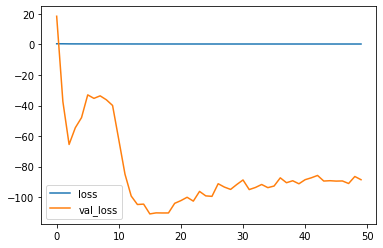

In [ ]:
history = model.fit(X_train , X_train , batch_size = 128 , epochs = 50, validation_data= (X_test, X_test))
pd.DataFrame(history.history).plot()

### OneShot

In [ ]:
num_classes = 10
epochs = 10

def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)


def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1.0, 0.0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    #x = Dense(128, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [ ]:
# create training+test positive and negative pairs
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]

tr_pairs, tr_y = create_pairs(X_train, digit_indices)
digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(X_test, digit_indices)

Epoch 1/10
78/78 [==============================] - 2s 16ms/step - loss: 0.1317 - accuracy: 0.8176 - val_loss: 0.1062 - val_accuracy: 0.8549
Epoch 2/10
78/78 [==============================] - 1s 12ms/step - loss: 0.1033 - accuracy: 0.8657 - val_loss: 0.1014 - val_accuracy: 0.8634
Epoch 3/10
78/78 [==============================] - 1s 12ms/step - loss: 0.0919 - accuracy: 0.8797 - val_loss: 0.0917 - val_accuracy: 0.8779
Epoch 4/10
78/78 [==============================] - 1s 15ms/step - loss: 0.0840 - accuracy: 0.8944 - val_loss: 0.0919 - val_accuracy: 0.8780
Epoch 5/10
78/78 [==============================] - 1s 12ms/step - loss: 0.0777 - accuracy: 0.9089 - val_loss: 0.0893 - val_accuracy: 0.8814
Epoch 6/10
78/78 [==============================] - 1s 12ms/step - loss: 0.0735 - accuracy: 0.9091 - val_loss: 0.0858 - val_accuracy: 0.8864
Epoch 7/10
78/78 [==============================] - 1s 15ms/step - loss: 0.0693 - accuracy: 0.9192 - val_loss: 0.0901 - val_accuracy: 0.8814
Epoch 8/10
78

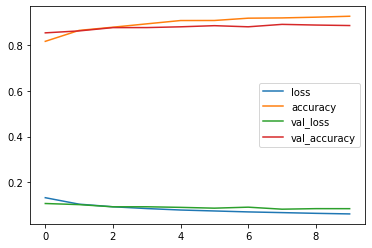

In [ ]:
input_shape = X_train.shape[1:]

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

model.compile(loss=contrastive_loss, optimizer="rmsprop", metrics=[accuracy])
# train
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=128,
          epochs=epochs,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))

pd.DataFrame(history.history).plot()

In [ ]:
# compute final accuracy on training and test sets
y_pred_tr = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred_tr)
y_pred_te = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred_te)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

625/625 [==============================] - 1s 2ms/step
* Accuracy on training set: 93.39%
* Accuracy on test set: 88.68%


### FFNN

In [ ]:
def CNN_deep_1(shape):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(10, activation='softmax'))
  #model.summary()

  return model 

def CNN_deep(shape):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), padding= "same", activation='relu', input_shape = shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))
  model.add(Conv2D(64, padding='same',  kernel_size=(3, 3), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  model.summary()

  return model 

### Train

In [ ]:
import time 

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

class mini_batch_sampling(tf.keras.utils.Sequence):
  def __init__(self, images, labels, batch_size=128, shuffle=True):
    super().__init__()
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.shuffle = shuffle
    key_array = []
    self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)
    self.on_epoch_end()

  def __len__(self):
    return len(self.key_array)//self.batch_size

  def __getitem__(self, index):
    keys = self.key_array[index*self.batch_size:(index+1)*self.batch_size]

    x = np.asarray(self.images[keys], dtype=np.float32)
    y = np.asarray(self.labels[keys], dtype=np.float32)


    return x, y

  def on_epoch_end(self):
    if self.shuffle:
      self.key_array = np.random.permutation(self.key_array)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 3136)             

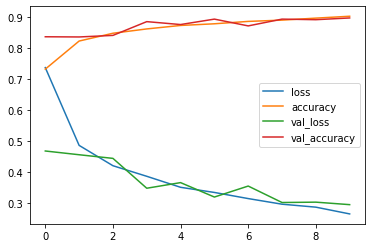

In [ ]:
#Creating the models 
epochs = 10
batch_size = 64
shape = (28,28,1)

model = CNN_deep(shape)

global model

#Creating the generator
generator_uniform = mini_batch_sampling(images = X_train, labels = y_train , batch_size = batch_size, shuffle = True)


#Compile
model.compile("adam", loss = ['sparse_categorical_crossentropy'] , metrics = ["accuracy"])

#Fit
time_callback = TimeHistory()
history = model.fit_generator(generator_uniform, epochs=epochs, 
                    validation_data = (X_val, y_val), verbose=1, callbacks = [time_callback])

print(time_callback.times)
pd.DataFrame(history.history).plot()

In [ ]:
class DPP_RBF_Fast_Autoencoder(tf.keras.utils.Sequence):
  def __init__(self, images, labels, batch_size=128, N = 100, shuffle=True):
    super().__init__()
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.N = N
    key_array = []
    self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)
    self.on_epoch_end()
    self.embedded_image = encoder.predict(images)

  def __len__(self):
    return len(self.key_array) // self.N

  def __getitem__(self, index):
    #keys = self.key_array[index*self.N:(index+1)*self.N]
    print(f'Key Array Shape: {len(self.key_array)}')

    if len(self.key_array) > self.N:

      random_keys = np.random.choice(self.key_array , self.N , replace = False)

    else:

      random_keys = self.key_array

    tmp_x = self.images[random_keys]
    tmp_y = self.labels[random_keys]

    tmp_x_embedded = self.embedded_image[random_keys]

    """DPP = FiniteDPP('likelihood',
                    **{'L_eval_X_data': (self.kernel, tmp_x.reshape( (len(tmp_x) , 2) ) )})
    
    #DPP.sample_mcmc_k_dpp(size=self.batch_size)
    DPP.sample_exact_k_dpp(size=self.batch_size)
    #keys_DPP = DPP.list_of_samples[0][0]
    keys_DPP = DPP.list_of_samples[0]"""

    dpp = DPP(tmp_x_embedded)
    dpp.compute_kernel(kernel_type = 'rbf', sigma= 10)                  
    keys_DPP = dpp.sample_k(batch_size) 

    x = np.asarray(tmp_x[keys_DPP], dtype=np.float32)
    y = np.asarray(tmp_y[keys_DPP], dtype=np.float32)

    #self.key_array = np.delete(self.key_array , keys_DPP)
    self.key_array = self.key_array[~np.isin(self.key_array, random_keys)]

    return x, y

  def on_epoch_end(self):
    self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 3136)             

Epoch 1/10
Key Array Shape: 15700
Key Array Shape: 15400
      1/Unknown - 1s 875ms/step - loss: 2.2971 - accuracy: 0.1094Key Array Shape: 15100
      2/Unknown - 1s 301ms/step - loss: 2.2675 - accuracy: 0.1484Key Array Shape: 14800
      3/Unknown - 1s 305ms/step - loss: 2.1871 - accuracy: 0.2240Key Array Shape: 14500
      4/Unknown - 2s 302ms/step - loss: 2.1363 - accuracy: 0.2461Key Array Shape: 14200
      5/Unknown - 2s 291ms/step - loss: 2.0941 - accuracy: 0.2750Key Array Shape: 13900
      6/Unknown - 2s 295ms/step - loss: 2.0423 - accuracy: 0.2839Key Array Shape: 13600
      7/Unknown - 3s 296ms/step - loss: 1.9878 - accuracy: 0.3080Key Array Shape: 13300
      8/Unknown - 3s 301ms/step - loss: 1.9328 - accuracy: 0.3320Key Array Shape: 13000
      9/Unknown - 3s 296ms/step - loss: 1.8797 - accuracy: 0.3490Key Array Shape: 12700
     10/Unknown - 4s 297ms/step - loss: 1.8253 - accuracy: 0.3719Key Array Shape: 12400
     11/Unknown - 4s 299ms/step - loss: 1.7887 - accuracy: 0.39

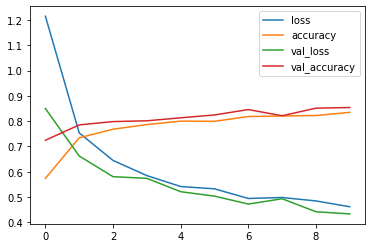

In [ ]:
#Creating the models 
epochs = 10
batch_size = 64
shape = (28,28,1)

model = CNN_deep(shape)
global model

#Creating the generator
generator_DPP = DPP_RBF_Fast_Autoencoder(images = X_train, labels=y_train, 
                        batch_size=batch_size, N = 300, shuffle=False)


#Compile
model.compile("adam", loss = ['sparse_categorical_crossentropy'] , metrics = ["accuracy"])

#Fit
time_callback = TimeHistory()

history = model.fit_generator(generator_DPP, epochs=epochs, steps_per_epoch =-1, 
                              validation_data=(X_val, y_val), verbose=1, callbacks = [time_callback])

#print(time_callback.times)
pd.DataFrame(history.history).plot()

In [ ]:
class DPP_RBF_Fast_OneShot(tf.keras.utils.Sequence):
  def __init__(self, images, labels, batch_size=128, N = 100, shuffle=True):
    super().__init__()
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.N = N
    key_array = []
    self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)
    self.on_epoch_end()
    self.embedded_image = base_network.predict(images)

  def __len__(self):
    return len(self.key_array) // self.N

  def __getitem__(self, index):
    #keys = self.key_array[index*self.N:(index+1)*self.N]
    print(f'Key Array Shape: {len(self.key_array)}')

    if len(self.key_array) > self.N:

      random_keys = np.random.choice(self.key_array , self.N , replace = False)

    else:

      random_keys = self.key_array

    tmp_x = self.images[random_keys]
    tmp_y = self.labels[random_keys]

    tmp_x_embedded = self.embedded_image[random_keys]

    """DPP = FiniteDPP('likelihood',
                    **{'L_eval_X_data': (self.kernel, tmp_x.reshape( (len(tmp_x) , 2) ) )})
    
    #DPP.sample_mcmc_k_dpp(size=self.batch_size)
    DPP.sample_exact_k_dpp(size=self.batch_size)
    #keys_DPP = DPP.list_of_samples[0][0]
    keys_DPP = DPP.list_of_samples[0]"""

    dpp = DPP(tmp_x_embedded)
    dpp.compute_kernel(kernel_type = 'rbf', sigma= 10)                  
    keys_DPP = dpp.sample_k(batch_size) 

    x = np.asarray(tmp_x[keys_DPP], dtype=np.float32)
    y = np.asarray(tmp_y[keys_DPP], dtype=np.float32)

    #self.key_array = np.delete(self.key_array , keys_DPP)
    self.key_array = self.key_array[~np.isin(self.key_array, random_keys)]

    return x, y

  def on_epoch_end(self):
    self.key_array = np.arange(self.images.shape[0], dtype=np.uint32)

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_60 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_61 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_61 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 flatten_32 (Flatten)        (None, 3136)            

Epoch 1/10
Key Array Shape: 15700
Key Array Shape: 15400
      1/Unknown - 1s 992ms/step - loss: 2.3219 - accuracy: 0.0469Key Array Shape: 15100
      2/Unknown - 1s 342ms/step - loss: 2.2936 - accuracy: 0.1562Key Array Shape: 14800
      3/Unknown - 2s 344ms/step - loss: 2.2504 - accuracy: 0.2135Key Array Shape: 14500
      4/Unknown - 2s 355ms/step - loss: 2.2091 - accuracy: 0.2539Key Array Shape: 14200
      5/Unknown - 2s 344ms/step - loss: 2.1700 - accuracy: 0.2812Key Array Shape: 13900
      6/Unknown - 3s 337ms/step - loss: 2.1225 - accuracy: 0.3151Key Array Shape: 13600
      7/Unknown - 3s 348ms/step - loss: 2.0786 - accuracy: 0.3192Key Array Shape: 13300
      8/Unknown - 3s 346ms/step - loss: 2.0408 - accuracy: 0.3281Key Array Shape: 13000
      9/Unknown - 4s 347ms/step - loss: 1.9945 - accuracy: 0.3507Key Array Shape: 12700
     10/Unknown - 4s 354ms/step - loss: 1.9533 - accuracy: 0.3656Key Array Shape: 12400
     11/Unknown - 5s 357ms/step - loss: 1.9352 - accuracy: 0.37

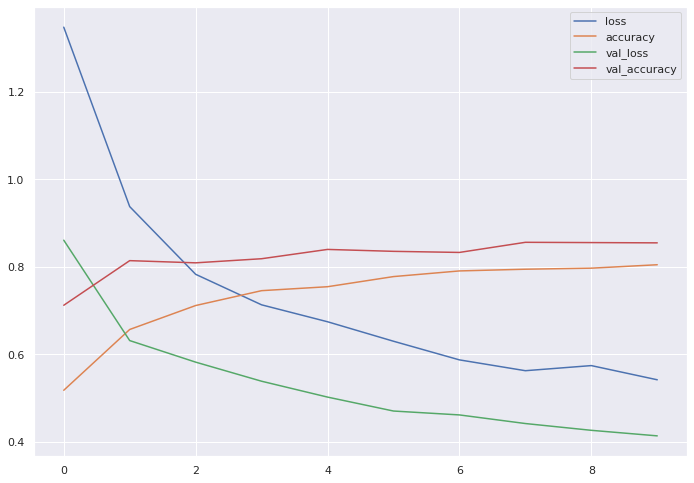

In [ ]:
#Creating the models 
epochs = 10
batch_size = 64
shape = (28,28,1)

model = CNN_deep(shape)
global model

#Creating the generator
generator_DPP = DPP_RBF_Fast_OneShot(images = X_train, labels=y_train, 
                        batch_size=batch_size, N = 300, shuffle=False)


#Compile
model.compile("adam", loss = ['sparse_categorical_crossentropy'] , metrics = ["accuracy"])

#Fit
time_callback = TimeHistory()

history = model.fit_generator(generator_DPP, epochs=epochs, steps_per_epoch =-1, 
                              validation_data=(X_val, y_val), verbose=1, callbacks = [time_callback])

#print(time_callback.times)
pd.DataFrame(history.history).plot()

In [ ]:
from IPython.display import display, clear_output

def cum_sum(time_list):
  cumtime = time_list[0]
  cumsum = [cumtime]
  for time in time_list[1:]:
    cumtime += time
    cumsum.append(cumtime)

  return cumsum

def plot_confidence(n):

  #Creating the models 
  epochs = 10
  batch_size = 64
  shape = (28,28,1)
  historial = pd.DataFrame()
  

  for i in range(n):
    
    print(f'Iteration: {i}')

    #####################
    #Baseline
    #####################
    
    model = CNN_deep(shape)
    #global model

    #Creating the generator
    generator_uniform = mini_batch_sampling(images = X_train, labels = y_train , batch_size = batch_size, shuffle = True)

    #Compile
    model.compile("adam", loss = ['sparse_categorical_crossentropy'] , metrics = ["accuracy"])

    #Fit
    time_callback = TimeHistory()

    history = model.fit_generator(generator_uniform, epochs=epochs, 
                        validation_data = (X_val, y_val), verbose=1, callbacks = [time_callback])

    
    history = pd.DataFrame(history.history)
    
        
    loss = history[["loss"]]
    loss["val_loss"] = history[["val_loss"]]
    loss["val_accuracy"] = history[["val_accuracy"]]
    loss["time"] =  np.array(time_callback.times).cumsum()
    loss["epoch"] = list(range(1,epochs+1))
    loss["method"] = "baseline"
    #loss["time"] = cum_sum(time_list)
    historial = pd.concat([historial , loss], axis = 0)

    clear_output(wait=True)

    #####################
    #DPP AutoEncoder
    #####################
    
    model = CNN_deep(shape)
    #global model

    #Creating the generator
    generator_DPP = DPP_RBF_Fast_Autoencoder(images = X_train, labels=y_train, 
                            batch_size=batch_size, N = 400, shuffle=False)


    #Compile
    model.compile("adam", loss = ['sparse_categorical_crossentropy'] , metrics = ["accuracy"])

    #Fit
    time_callback = TimeHistory()

    history_DPP = model.fit_generator(generator_DPP, epochs=epochs, steps_per_epoch =-1, 
                                  validation_data=(X_val, y_val), verbose=1, callbacks = [time_callback])


    history_DPP = pd.DataFrame(history_DPP.history)

    loss = history_DPP[["loss"]]
    loss["val_loss"] = history_DPP[["val_loss"]]
    loss["val_accuracy"] = history_DPP[["val_accuracy"]]
    loss["epoch"] = list(range(1, epochs+1))
    loss["time"] =  np.array(time_callback.times).cumsum()
    loss["method"] = "DPP AutoEncoder"
    #loss["time"] = cum_sum(time_list_DPP)
    historial = pd.concat([historial , loss], axis = 0)

    clear_output(wait=True)

    #####################
    #DPP OneShot
    #####################
    
    model = CNN_deep(shape)
    #global model

    #Creating the generator
    generator_DPP = DPP_RBF_Fast_OneShot(images = X_train, labels=y_train, 
                            batch_size=batch_size, N = 400, shuffle=False)

    #Compile
    model.compile("adam", loss = ['sparse_categorical_crossentropy'] , metrics = ["accuracy"])

    #Fit
    time_callback = TimeHistory()

    history_DPP = model.fit_generator(generator_DPP, epochs=epochs, steps_per_epoch =-1, 
                                  validation_data=(X_val, y_val), verbose=1, callbacks = [time_callback])


    history_DPP = pd.DataFrame(history_DPP.history)

    loss = history_DPP[["loss"]]
    loss["val_loss"] = history_DPP[["val_loss"]]
    loss["val_accuracy"] = history_DPP[["val_accuracy"]]
    loss["epoch"] = list(range(1, epochs+1))
    loss["time"] =  np.array(time_callback.times).cumsum()
    loss["method"] = "DPP OneShot"
    #loss["time"] = cum_sum(time_list_DPP)
    historial = pd.concat([historial , loss], axis = 0)

    clear_output(wait=True)


  historial.reset_index(drop = True , inplace = True)


  return historial

train_historial = plot_confidence(n = 5)
train_historial

,loss,val_loss,val_accuracy,time,epoch,method
0,0.738426,0.452394,0.847500,20.145637,1,baseline
1,0.490685,0.400519,0.860000,40.897284,2,baseline
2,0.423857,0.389144,0.865625,60.334256,3,baseline
3,0.381614,0.370231,0.876250,79.712816,4,baseline
4,0.354508,0.335736,0.885000,99.120460,5,baseline
...,...,...,...,...,...,...
145,0.711806,0.554419,0.800625,109.114061,6,DPP OneShot
146,0.662477,0.547460,0.797500,127.499233,7,DPP OneShot
147,0.654569,0.501106,0.827500,145.853618,8,DPP OneShot
148,0.605705,0.524537,0.796250,163.909595,9,DPP OneShot


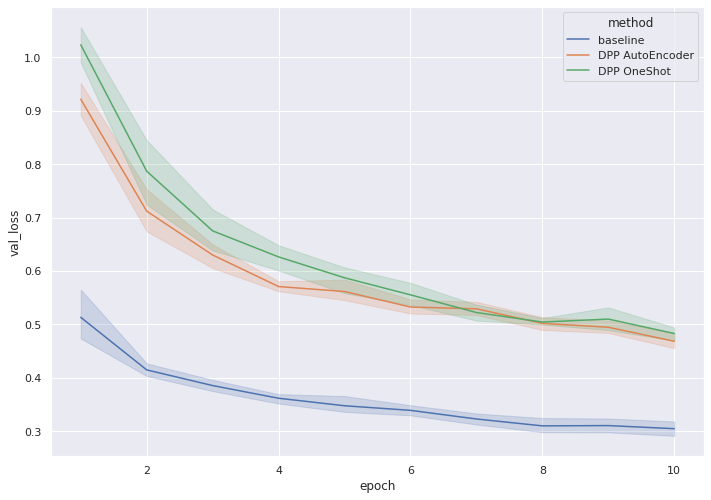

In [ ]:
import seaborn as sns 

#Plotting
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="epoch", y= "val_loss", hue = "method", data = train_historial)

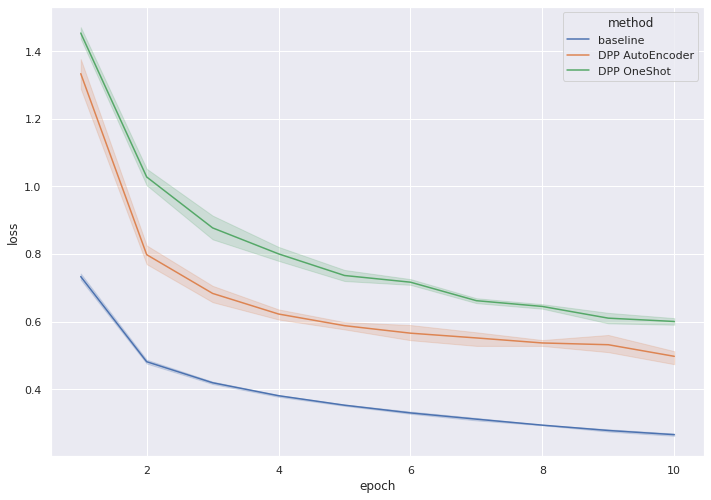

In [ ]:
#Plotting
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="epoch", y= "loss", hue = "method", data = train_historial)

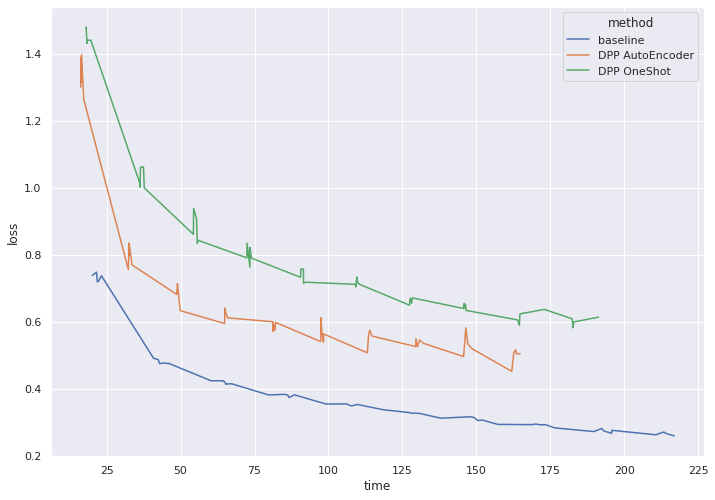

In [ ]:
#Plotting
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="time", y= "loss", hue = "method", data = train_historial)

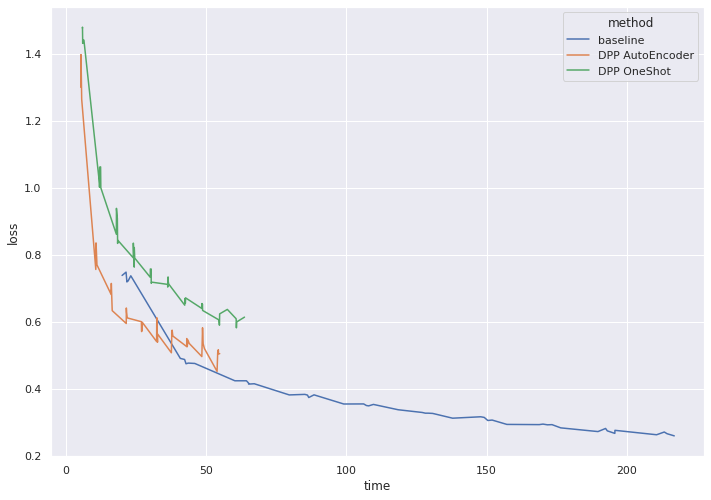

In [ ]:
#Plotting
train_historial_normalized = train_historial.copy()
train_historial_normalized.loc[train_historial_normalized.method == "DPP OneShot" , "time"] = train_historial_normalized.loc[train_historial_normalized.method == "DPP OneShot" , "time"] / 3
train_historial_normalized.loc[train_historial_normalized.method == "DPP AutoEncoder" , "time"] = train_historial_normalized.loc[train_historial_normalized.method == "DPP AutoEncoder" , "time"] / 3
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(x="time", y= "loss", hue = "method", data = train_historial_normalized)